# Example to Illustrate the Curse of Dimensionality

The **Curse of Dimensionality** states that the more dimensions to your data (features), the worse a model's performance will be in terms of training time and prediction power. In this notebook we'll exemplify this issue by simulating a two-class classification problem as well as several features and test different models.

## Methodology

### Simulating a Dataset

True labels will come from two bi-variate normal distributions, which will be parametrized such that they have limited overlap.

Each distribution will provide 500 samples.

An additional 1000 features will be drawn randomly from a standard normal distribution.

### Metrics of Interest

We'll study the following metrics:

* training time,
* area under ROC curve from 5-fold cross validation, and
* area under ROC curve on a test set as a measure of out-of-sample performance

across several different approaches to solving a classification problem.

**Notes:**

1. We'll use default hyperparameters for the models because the point is to illustrate the phenomenon, not create the best possible models.

## Results

1. Logistic Regression began showing numerical issues with around 800 features.
2. The largest train and prediction times happened with around 400 features using the Gaussian Process Classifier. Ignoring this observation, train and prediction times are monotonic with the number of features across all models.
3. Logistic Regression, K Nearest Neighbors and Decision Trees are the most resilient models to number of features.
4. XGBoost and SVM show the worst training time performance when feature dimensionality increases.
5. Prediction times are somewhat similar, all under 1 second.
6. XGBoost shows poor training time performance and is among the most efficient during prediction. K Nearest Neighbors shows the opposite behaviour.
7. There was little difference between in-sample and out-of-sample performances across models, and all show a monotonic decrease as feature space grows.
8. Linear Regression, Decision Trees, and XGBoost are resilient to feature increases; on the other hand Gaussian Process Classifier and Extra Trees Classifier are very sensible to a noisy feature space.

## Setup

In [1]:
%matplotlib inline

# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from time import perf_counter

# import models
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


# Set random seed for replicability.
np.random.seed(42)
# Set figure size.
sns.set(rc={'figure.figsize':(15, 8)})

# Expriment characteristics.
N_FEATURES = 1000
N_OBSERVATIONS = 500
N_RUNS = 25

## The Problem:

We'll simulate a two-dimensional classification problem using two normal distributions.

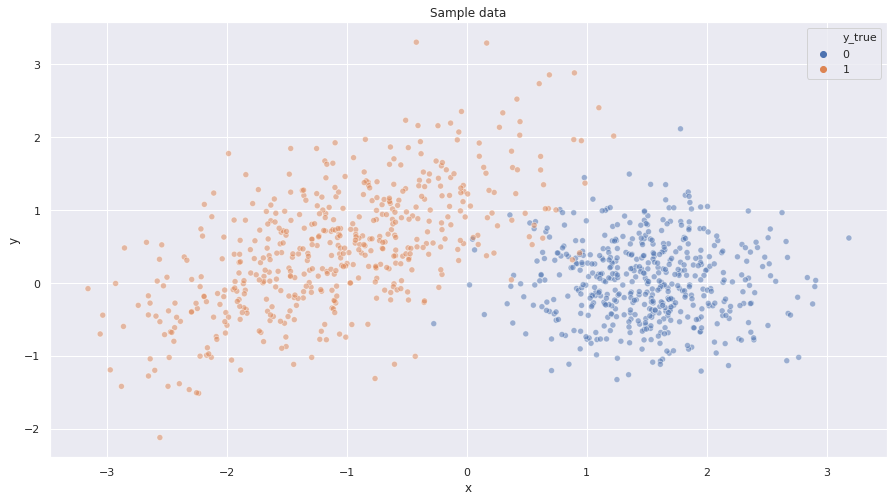

In [2]:
# Define classes' true parameters
classes = {
    0: {'mean': np.array([1.5, 0]), 'cov': np.array([[0.3, 0],[0, 0.3]]), 'size': N_OBSERVATIONS},
    1: {'mean': np.array([-1, 0.5]), 'cov': np.array([[0.75, 0.5],[0.5, 0.75]]), 'size': N_OBSERVATIONS},                                            
}

# Simulate data for each class.
X = pd.DataFrame()
for class_, opts in classes.items():
    aux = pd.DataFrame(np.random.multivariate_normal(**opts))
    aux.columns=['x', 'y']
    aux['y_true'] = class_
    X = X.append(aux)
# Cleanup
del aux

# Plot sample
ax = sns.scatterplot(data=X, x='x', y='y', alpha=.5, hue=X.y_true)
ax.set_title('Sample data');

## Add New Features

We'll create 100 random features to go with our data.

In [3]:
X = X.join(pd.DataFrame(np.random.normal(size=(len(X), N_FEATURES))))

## Perform Train-Test Splits

In [4]:
y = X['y_true']
X = X.drop('y_true', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Run Experiment

1. All models will contain the x and y features.
2. Each model will be trained and the following metrics will be computed:
    * training time for a single fold,
    * area under ROC curve from 5-fold cross validation, and
    * area under ROC curve on a test set as a measure of out-of-sample performance
3. We'll add features in increments of 10 features.

In [5]:
models = [
    {'type': LogisticRegression, 'train_kwargs': {'random_state': 42}},
    {'type': ExtraTreesClassifier, 'train_kwargs': {'random_state': 42}},
    {'type': GaussianProcessClassifier, 'train_kwargs': {'random_state': 42}},
    {'type': KNeighborsClassifier, 'train_kwargs': {}},
    {'type': DecisionTreeClassifier, 'train_kwargs': {'random_state': 42}},
    {'type': SVC, 'train_kwargs': {'random_state': 42, 'probability': True}},
    {'type': XGBClassifier, 'train_kwargs': {'random_state': 42}},
]

base_features = ['x', 'y']

results = pd.DataFrame()

for experiment in range(N_RUNS+1):  # Run 0 is the benchmark using only x and y
    features = base_features + list(range(experiment * N_FEATURES // N_RUNS))
    print(f'Training models with {len(features)} features.')

    for params in models:
        model = params['type']
        train_kwargs = params['train_kwargs']
        
        mod = model(**train_kwargs)

        before_train = perf_counter()
        mod.fit(X_train[features], y_train)
        after_train = perf_counter()

        before_predict = perf_counter()
        oos = mod.predict_proba(X_test[features])[:,1]
        after_predict = perf_counter()

        cval = cross_val_score(mod, X_train[features], y_train, cv=5, scoring='roc_auc')

        model_results = pd.DataFrame(index=[0])
        # Experiment parameters
        model_results['model'] = model.__name__
        model_results['n_feats'] = len(features)
        # Metrics
        model_results['train_time'] = after_train - before_train
        model_results['predict_time'] = after_predict - before_predict
        model_results['oos_performance'] = roc_auc_score(y_true=y_test, y_score=oos)
        model_results['ins_performance'] = np.mean(cval)
        # Update results    
        results = results.append(model_results)

Training models with 2 features.
Training models with 42 features.
Training models with 82 features.
Training models with 122 features.
Training models with 162 features.
Training models with 202 features.
Training models with 242 features.
Training models with 282 features.
Training models with 322 features.
Training models with 362 features.
Training models with 402 features.
Training models with 442 features.
Training models with 482 features.
Training models with 522 features.
Training models with 562 features.
Training models with 602 features.
Training models with 642 features.
Training models with 682 features.
Training models with 722 features.
Training models with 762 features.
Training models with 802 features.


/home/icarus/virtualenvs/base_venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training models with 842 features.


/home/icarus/virtualenvs/base_venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/icarus/virtualenvs/base_venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

Training models with 882 features.


/home/icarus/virtualenvs/base_venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/icarus/virtualenvs/base_venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

Training models with 922 features.


/home/icarus/virtualenvs/base_venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/icarus/virtualenvs/base_venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

Training models with 962 features.


/home/icarus/virtualenvs/base_venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/icarus/virtualenvs/base_venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

Training models with 1002 features.


/home/icarus/virtualenvs/base_venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/icarus/virtualenvs/base_venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

## Analyze results

In [45]:
palette = 'deep'

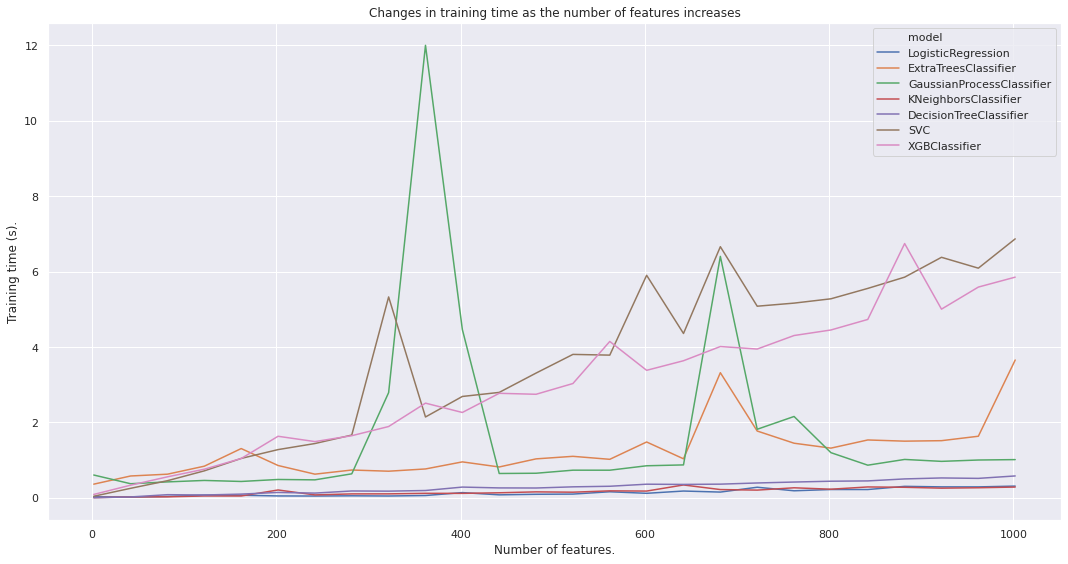

In [50]:
ax = sns.lineplot(x='n_feats', y='train_time', data=results, hue='model', palette=palette)
ax.set_title('Changes in training time as the number of features increases')
ax.set_xlabel('Number of features.')
ax.set_ylabel('Training time (s).')
plt.tight_layout()
plt.savefig('curse_dimensionality_train_time.jpeg')

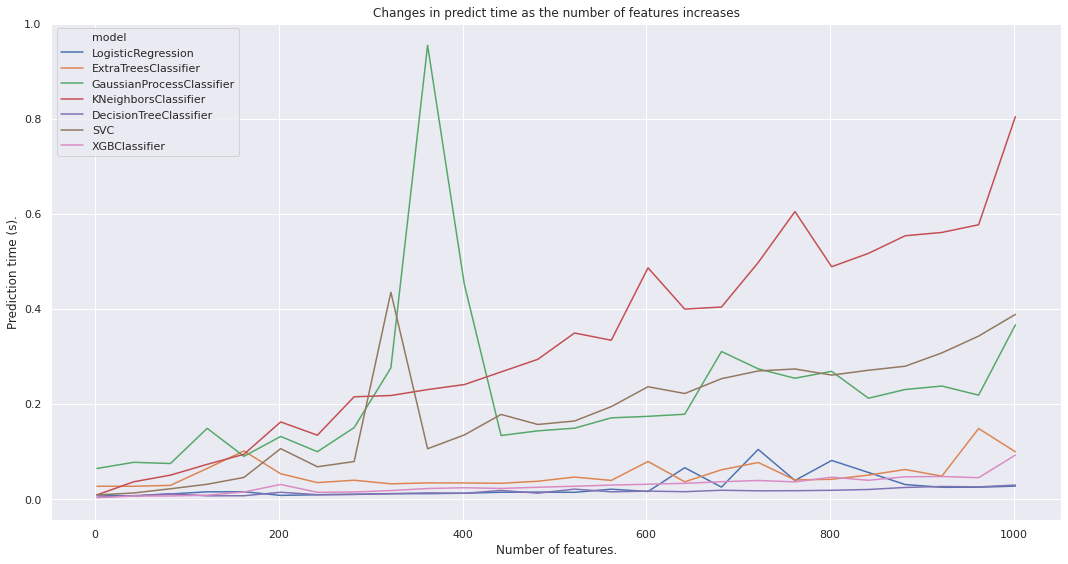

In [51]:
ax = sns.lineplot(x='n_feats', y='predict_time', data=results, hue='model', palette=palette)
ax.set_title('Changes in predict time as the number of features increases')
ax.set_xlabel('Number of features.')
ax.set_ylabel('Prediction time (s).')
plt.tight_layout()
plt.savefig('curse_dimensionality_predict_time.jpeg')

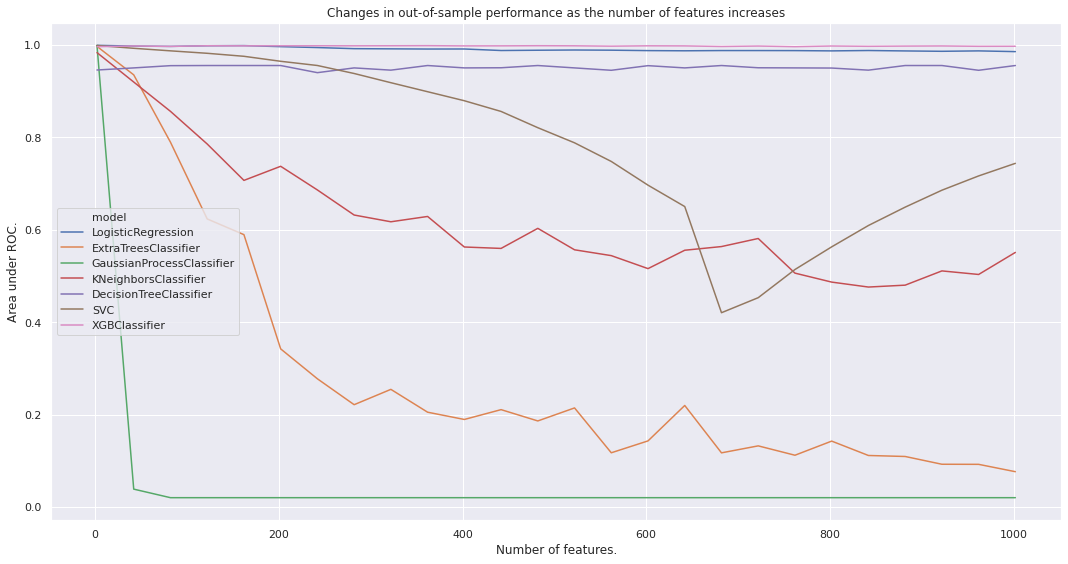

In [52]:
ax = sns.lineplot(x='n_feats', y='oos_performance', data=results, hue='model', palette=palette)
ax.set_title('Changes in out-of-sample performance as the number of features increases')
ax.set_xlabel('Number of features.')
ax.set_ylabel('Area under ROC.')
plt.tight_layout()
plt.savefig('curse_dimensionality_oos_performance.jpeg')

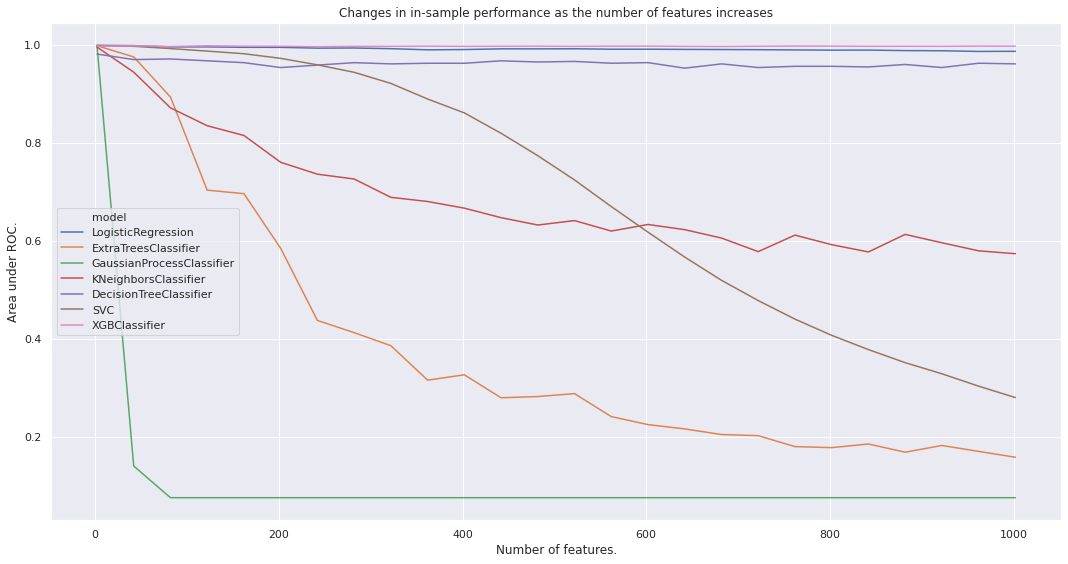

In [53]:
ax = sns.lineplot(x='n_feats', y='ins_performance', data=results, hue='model', palette=palette)
ax.set_title('Changes in in-sample performance as the number of features increases')
ax.set_xlabel('Number of features.')
ax.set_ylabel('Area under ROC.')
plt.tight_layout()
plt.savefig('curse_dimensionality_cv5_performance.jpeg')